In [1]:
from utilities.landxmlSDK.landxml import landxml
from utilities.landxmlSDK.dcmgeometry.geometry import Geometries
from utilities.landxmlSDK.dcmgeometry.polygons import PolygonGeom
from utilities.landxmlSDK.dcmgeometry.points import PointGeom
from utilities.landxmlSDK.geometryfunctions.transformationfunctions import helmert_trans_unknown
from utilities.landxmlSDK.geometryfunctions.bearingdistancefunctions import calc_distance, angle_differences, \
                                                                            process_angles, remove_stroked_curves
from utilities.landxmlSDK.geometryfunctions.otherfunctions import previous_and_next

import shapely.affinity as sa
import shapely.ops as so
import shapely.geometry as sg
import geopandas as gpd
import pandas as pd
import psycopg2
import boto3
import os
from pathlib import Path
from copy import deepcopy

In [2]:
def process_fetch(conn, sql, fall=True):
    cur = conn.cursor()
    cur.execute(sql)
    if fall is False:
        f = cur.fetchone()
    else:
        f = cur.fetchall()
    return f

def get_plan_location_from_spi(conn, spis):
    spis = "', '".join(spis)
    sql = f"SELECT s.xml_bucket, s.working_folder, s.plan_number, esn.spi_name \
            FROM extracted_spi_names esn \
            LEFT JOIN ( \
            SELECT cpd.xml_bucket, cpd.working_folder, cp.plan_number, cp.ext_plan_id \
            FROM capturedplans cp \
            LEFT JOIN capturedplansdetails cpd \
            ON cpd.captured_plan_id = cp.id \
            WHERE cp.afr_version IS Null AND cp.retire_date is Null) AS s \
            ON esn.ext_plan_id = s.ext_plan_id \
            WHERE esn.spi_name in ('{spis}')"
    
    xml_details = process_fetch(conn, sql)
    
    #conn.close()
    
    plan_details = {}
    for item in xml_details:
        bucket, location, plan_number, spiname = item
        plan = plan_details.get(plan_number, {})
        if len(plan) == 0:
            plan['location'] = location
            plan['bucket'] = bucket
            plan['spis'] = [spiname]
        else:
            plan['spis'].append(spiname)
        plan_details[plan_number] = plan
    return plan_details
    
    

In [3]:
session = boto3.Session(profile_name='work-prod')
s3 = session.client('s3')

In [4]:
out_xmls = '/Users/jamesleversha/Downloads/test_area_queenscliffe/test_files'

In [5]:
lines = gpd.read_file('/Users/jamesleversha/Downloads/test_area_queenscliffe/test_area/vicmap_lines.shp')

In [6]:

lines['len'] = lines.geometry.apply(lambda x: len(x.coords[:]))
lines_reduced = lines.loc[lines.len > 2].copy()
#lines_reduced['geometry'] = lines_reduced.loc[lines_reduced['PFI'] == '406231175'].geometry.apply(identify_curves)
lines_reduced['geometry'] = lines_reduced.geometry.apply(remove_stroked_curves)


lines_reduced.to_file('/Users/jamesleversha/Downloads/test_area_queenscliffe/test_area/vicmap_curves_removed.shp')



In [7]:
polygons = gpd.read_file('/Users/jamesleversha/Downloads/test_area_queenscliffe/test_area/queenscliffe_all_parcels.shp')
points = gpd.read_file('/Users/jamesleversha/Downloads/queenscliffe.gpkg', layer='points')
spi_field = 'SPI'
#points = gpd.read_file('/Users/jamesleversha/Downloads/test_area_queenscliffe/test_area/points.shp')
polygons.crs = 7844
points.crs = 7844
polygons = polygons.to_crs(7855)
points = points.to_crs(7855)

/Users/jamesleversha/opt/anaconda3/envs/DigitalCadastre/lib/python3.8/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [8]:
polygons.shape

(3437, 10)

In [9]:
host = 'dcm-reporting-prd.cedrlzhnersp.ap-southeast-2.rds.amazonaws.com'
un = 'postgres'
db = 'postgres'
pw = '3x2bulGgdZ1xY'
try:
    conn = psycopg2.connect(database=db, user=un, password=pw, host=host)
    spis = polygons.dropna(subset=[spi_field])[spi_field].tolist()
    plan_details = get_plan_location_from_spi(conn, spis)
    conn.close()
finally:    
    conn.close()

In [10]:
def rubber_sheet(geom, polygon_source, polygon_target):
    # set some thresholds
    angle_threshold = 45
    bearing_threshold = 30
    distance_thresholds = [10, 5, 1]
    distance_threshold = 10

    for sp in polygon_source.polygon_points.get('all'):
        # get all target points and stick them in a multipoint closest point lookup.
        target_points = [polygon_target.point_lookup.get(p) for p in polygon_target.polygon_points.get('all')]

        point_value = polygon_source.point_lookup.get(sp)
        
        x = True
        if len(target_points) < 0:
            x = False
        while x is True:

            sp_angle = polygon_source.inner_angles.get(sp)
            # get nearest point
            tps = sg.MultiPoint(target_points)

            nearest = so.nearest_points(point_value, tps)
            distance = calc_distance(*nearest)

            tc = tuple(nearest[1].coords)[0]
            tp = polygon_target.coord_lookup.get(tc)

            tp_angle = polygon_target.inner_angles.get(tp)

            # check opposite
            z = True
            #this should be source polygon
            op_points = [polygon_source.point_lookup.get(p) for p in polygon_source.polygon_points.get('all')]
            angle_value, to_value, from_value = angle_differences(tp_angle, sp_angle)
            if (angle_value < angle_threshold and
                    to_value < bearing_threshold and
                    from_value < bearing_threshold and
                    distance < distance_threshold):
                while z is True:
                    ops = sg.MultiPoint(op_points)
                    op_nearest = so.nearest_points(nearest[1], ops)
                    op_distance = calc_distance(*op_nearest)
                    oc = tuple(op_nearest[1].coords)[0]
                    op = polygon_source.coord_lookup.get(oc)

                    if op == sp:
                        opposite = True
                        z = False
                    else:
                        # check opposite values
                        op_angle = polygon_source.inner_angles.get(op)
                        angle_value, to_value, from_value = angle_differences(op_angle, tp_angle)
                        if (angle_value < angle_threshold and
                                to_value < bearing_threshold and
                                from_value < bearing_threshold and
                                op_distance < distance_threshold and
                                op_distance < distance):  # has to be closer than the other way even if under threshold

                            op_points.pop(op_points.index(sg.Point(oc)))

                        else:
                            opposite = False
                            z = False
                            # if a point is closer but doesnt meet thresholds, check the next closest point.

                    if len(op_points) == 0:
                        z = False
         
                # set point value to new coordinate
                if opposite is True:
                    al_ass = geom.points[sp].associated_id
                    all_ass_dist = geom.points[sp].associated_id
                    if al_ass is None:                    
                        geom.points[sp].set_new_geometry(nearest[1])
                        geom.points[sp].set_associated_id(tp, distance)                                
                    else:
                        if distance < all_ass_dist:
                            geom.points[sp].set_new_geometry(nearest[1])
                            geom.points[sp].set_associated_id(tp, distance)
                        
                        
                    # geom.points[sp] = point_value
                    x = False
                else:
                    target_points.pop(target_points.index(sg.Point(tc)))
            else:
                target_points.pop(target_points.index(sg.Point(tc)))

            if len(target_points) == 0:
                # break loop if no close points are found
                x = False
    
    return geom

In [11]:
final_frames = {}
for plan_number, value in plan_details.items():
    if plan_number in {'PS317909B'}:
        print(plan_number)
        bucket = value['bucket']
        location = value['location']
        outpath = Path(out_xmls, plan_number)
        outpath.mkdir(exist_ok=True, parents=True)
        outfile = Path(outpath, plan_number + '.xml')
        if bucket is None or location is None:
            print(plan_number, 'noloc')
        elif outfile.exists() is False:
            s3.download_file(bucket, str(Path(location, plan_number + '.xml')), str(outfile))
        if outfile.exists():
            data = landxml.parse(outfile, silence=True, print_warnings=False)
            geom = Geometries(data)
            geom.recalc_geometries(swing=True)
            try:
                for spiname in value['spis']:   
                    target_geom = so.unary_union(polygons.loc[polygons[spi_field] == spiname]['geometry'].tolist()[0])
                    if isinstance(target_geom, sg.Polygon):
                        if len(target_geom.exterior.coords[:]) > 5:
                            target_geom = remove_stroked_curves(target_geom)    

                        polygon_target = PolygonGeom()
                        point_target = points[points.intersects(target_geom.buffer(.1))]

                        point_targets = {}
                        for item in point_target.itertuples():
                            point = PointGeom()
                            point.geometry = item.geometry
                            point.name = item.point_id
                            point.oid = item.point_id
                            point.crs = int(points.crs.to_authority()[1])
                            point.round_geometry(decimals=4)
                            point_targets[point.oid] = point

                        polygon_target = PolygonGeom()
                        polygon_target.create_polygon(target_geom, points=point_targets, name=spiname, 
                                                      crs=int(polygons.crs.to_authority()[1]), coord_decimals=4)

                        
                        polygon_source = geom.polygons.get(spiname, PolygonGeom())
                        if isinstance(polygon_source.geometry, sg.Polygon):
                            mat = helmert_trans_unknown(polygon_source, polygon_target)
                            transform_geom = deepcopy(geom)
                            transform_geom.apply_affine_transformation(mat=mat)            
                            polygon_source = transform_geom.polygons.get(spiname)
                            #geom = rubber_sheet(geom, polygon_source, polygon_target)
                        else:
                            print('source has not got a polygon', spiname, plan_number)
                    else:
                        print('target not a polygon', spiname, plan_number)

                geom.update_geometries()
                geom.write_geom_to_file(df_only=True)
                for k, v in geom.dataframes.items():
                    frames = final_frames.get(k, [])
                    frames.append(v)
                    final_frames[k] = frames
            except Exception as err:
                print(plan_number, err)
            

PS317909B


In [12]:
location='/Users/jamesleversha/Downloads/test_area_queenscliffe/test_files/all1.gpkg'

In [13]:
for k, v in final_frames.items():
    
    frame = pd.concat(v)
    frame = gpd.GeoDataFrame(frame.drop(columns=['geometry']), geometry=frame['geometry'], crs=7855)
    frame.to_file(location, driver='GPKG', layer=k)

IllegalArgumentException: Geometry must be a Point or LineString
IllegalArgumentException: Geometry must be a Point or LineString
IllegalArgumentException: Geometry must be a Point or LineString
IllegalArgumentException: Geometry must be a Point or LineString
IllegalArgumentException: Geometry must be a Point or LineString
IllegalArgumentException: Geometry must be a Point or LineString
IllegalArgumentException: Geometry must be a Point or LineString
IllegalArgumentException: Geometry must be a Point or LineString
IllegalArgumentException: Geometry must be a Point or LineString
IllegalArgumentException: Geometry must be a Point or LineString
IllegalArgumentException: Geometry must be a Point or LineString
IllegalArgumentException: Geometry must be a Point or LineString


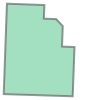

In [14]:
polygon_source.geometry

In [15]:
location

'/Users/jamesleversha/Downloads/test_area_queenscliffe/test_files/all1.gpkg'

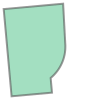

In [16]:
outfile = Path('/Users/jamesleversha/Downloads/test_area_queenscliffe/test_files/PS317909B/PS317909B.xml')
data = landxml.parse(outfile, silence=True, print_warnings=False)
geom = Geometries(data)
geom.recalc_geometries()

geom.polygons.get('1\\PS317909').geometry